<a href="https://colab.research.google.com/github/Swelem/obesity_risk/blob/main/lastproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import random
from PIL import Image

import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saifswelem","key":"93c4723ccbde8c247af262277f428b4b"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:

!mkdir /content/Dataset

mkdir: cannot create directory ‘/content/Dataset’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
os.chdir('/content/Dataset')

In [ ]:
!kaggle competitions download -c playground-series-s4e2


100% 917k/917k [00:00<00:00, 1.43MB/s]
100% 917k/917k [00:00<00:00, 1.43MB/s]


In [ ]:
!unzip playground-series-s4e2.zip

Archive:  playground-series-s4e2.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [28]:
given_test_data = pd.read_csv('/content/Dataset/test.csv')


given_train_data = pd.read_csv('/content/Dataset/train.csv')

In [29]:
given_train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [30]:
given_test_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [31]:
print(given_train_data.shape)
print(given_test_data.shape)

(20758, 18)
(13840, 17)


In [32]:
print(given_train_data["NObeyesdad"].unique())
class_counts = given_train_data["NObeyesdad"].value_counts()
class_counts

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

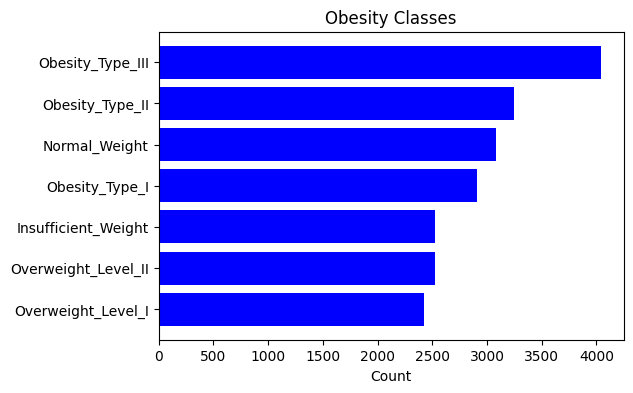

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(class_counts.index, class_counts.values, color="blue")
plt.xlabel("Count")
plt.title("Obesity Classes")
plt.gca().invert_yaxis() ## Invert the y-axis to show the highest frequency class at the top
plt.show()

In [36]:
categorical_features = given_train_data.select_dtypes(include=['object']).columns
continuous_features = given_train_data.select_dtypes(include=['float64','int64']).columns
## Export categorical and continuous data to separate DataFrames

data_cat = given_train_data[categorical_features]
data_cont = given_train_data[continuous_features]
print(data_cat.columns)
print(data_cont.columns)

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')
Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')


In [37]:
data_id= data_cont["id"]
data_cont.drop('id',axis=1, inplace=True)

<ipython-input-37-6bfb34d38753>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cont.drop('id',axis=1, inplace=True)


<ipython-input-38-7f820125f9b5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
<ipython-input-38-7f820125f9b5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
<ipython-input-38-7f820125f9b5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
<ipython-input-38-7f820125f9b5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

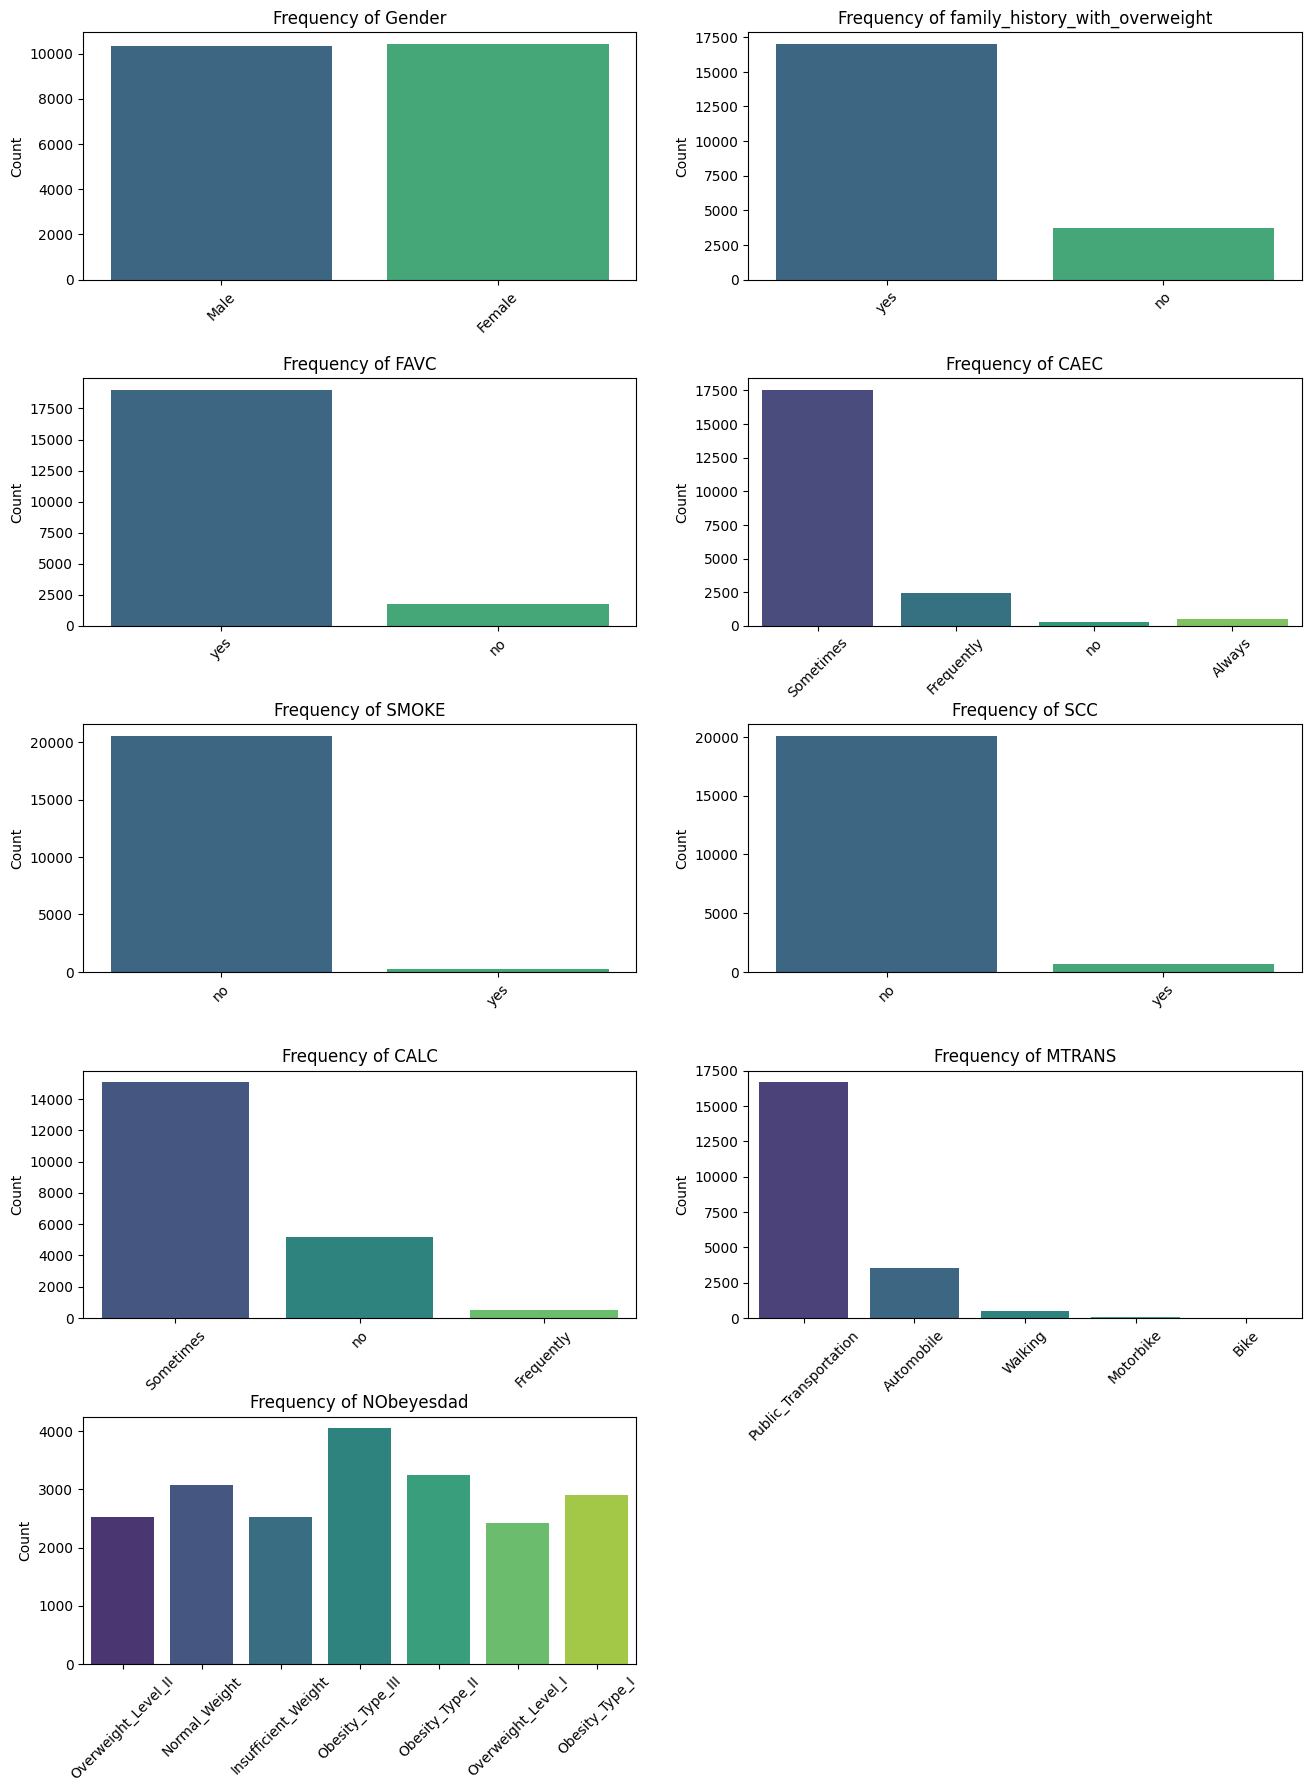

In [38]:
import seaborn as sns

## Drawing a frequency graph for each categorical variable
fig, axes = plt.subplots(nrows=(len(data_cat.columns)+1) // 2, ncols=2,figsize=(14, len(data_cat.columns) * 2))
fig.tight_layout(pad=5.0)

## Adjustment for proper positioning of the axes
axes = axes.ravel()

for i, col in enumerate(data_cat.columns):
    sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Frequency of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

## Closing extra created axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()